### Imports

In [5]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [6]:
batch_size = 64
sampled_graphs = 20

learning_rate_mlp = 0.01            #Paper: 0.003, code 0.01, codePyG 0.0003
coefficientSizeReg = 0.01           #Paper: 0.05, code 0.01, codePyG 0.005
entropyReg = 0.01                   #Paper: 1, code 0.01, codePyG 1
epochs_mlp = 20                     #Paper: 30 for all datasets => code uses 10

# Temperature
t_0 =  5.0
t_T = 5.0                           #Paper says 2.0, Code say 5.0, uses 1.0 , codePyG 5.0 =>

datasetName: Literal['BA-2Motif','MUTAG'] = 'MUTAG'
MUTAG = True        
# MUTAG DATASET SHAPE
# edge_attr: "valence" [edges, 3], contains bond type: Single, double triple
# x: "chem" [nodes, 14], node features:
# 0  1  2  3  4  5  6  7  8  9  10  11  12  13
# C  O  C1 H  N  F  Br S  P  I  Na  K   Li  Ca
# y: graph label, 0 mutagenic 1 nonmutagenic            MUTAGENIC: N(blue) H2(green), N(blue) O2(red)
# TODO: Original uses adapted dataset that contains Mutagenicity_edge_gt! => To only get graphs that are mutagenic and contain NO2 and NH2 motifs

### Load and visualize data

ORIGINAL
[(0, 1), (1, 0), (0, 2), (2, 0), (0, 3), (3, 0), (1, 4), (4, 1), (1, 5), (5, 1), (2, 6), (6, 2), (3, 7), (7, 3), (4, 8), (8, 4), (5, 9), (9, 5), (6, 10), (10, 6), (7, 11), (11, 7), (8, 12), (12, 8), (10, 13), (13, 10), (11, 14), (14, 11), (11, 15), (15, 11), (12, 16), (16, 12), (6, 8), (8, 6), (7, 9), (9, 7), (13, 16), (16, 13), (3, 17), (17, 3), (5, 18), (18, 5), (9, 19), (19, 9), (10, 20), (20, 10), (12, 21), (21, 12), (13, 22), (22, 13), (16, 23), (23, 16)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TRANSFORMED
tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  3,  7,  4,  8,  5,  9,
          6, 10,  7, 11,  8, 12, 10, 13, 11, 14, 11, 15, 12, 16,  6,  8,  7,  9,
         13, 16,  3, 17,  5, 18,  9, 19, 10, 20, 12, 21, 13, 22, 16, 23],
        [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  3,  8,  4,  9,  5,
         10,  6, 11,  7, 12,  8, 13, 10,

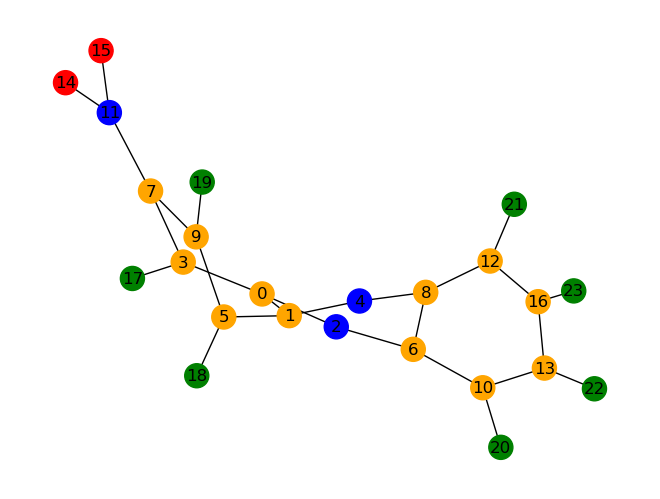

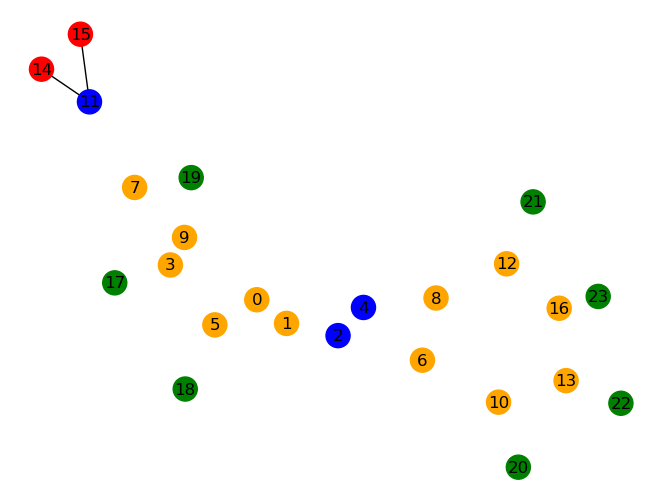

In [7]:
edge_lists, graph_labels, edge_label_lists, node_label_lists = datasetLoader.loadOriginalMUTAG()
data = datasetLoader.transformMUTAG(edge_lists, graph_labels, edge_label_lists, node_label_lists)


currData = data[22]

print("ORIGINAL")
print(edge_lists[22])
print(edge_label_lists[22])

print("TRANSFORMED")
print(currData.edge_index)
print(currData.gt_mask)
print(currData.x)
print(currData.y)

print(currData.edge_index[:,currData.gt_mask])


graphGT = Data(currData.x, currData.edge_index[:,currData.gt_mask])

pos = utils.plotGraph(currData, MUTAG=MUTAG)
pos2 =utils.plotGraph(graphGT, pos, MUTAG=MUTAG)

Processing...
Done!


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

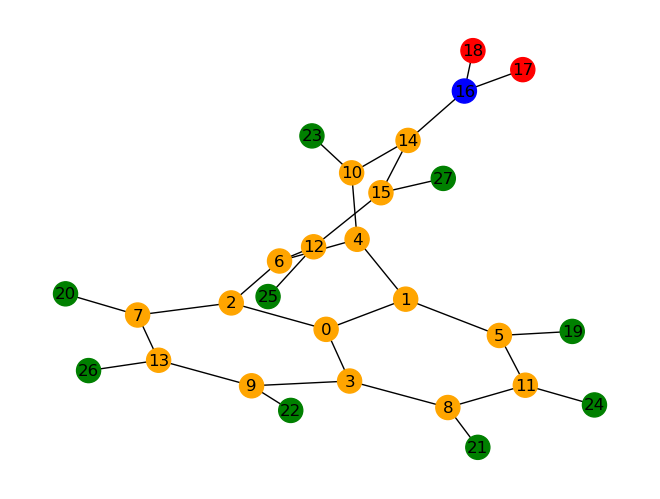

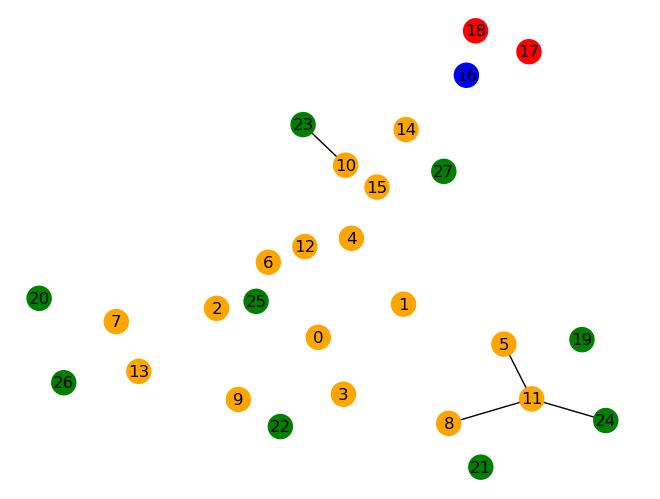

In [21]:
# TODO: MUTAG NEEDS TO BE PREPROCESSED: Extract all mutagenic NO2 and NH2 graphs, train and eval on only those!
# TODO: EXTRACT GROUND TRUTHS?? => Edge labels = edge_gt

data, labels = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)
print(data[0].x)
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)
train_loader = DataLoader(train_dataset, batch_size, False)
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

print(test_dataset[len(test_dataset)-1].gt_mask)

currData = test_dataset[len(test_dataset)-5]
print(currData.gt_mask)
print(currData.y)
print(torch.argmax(currData.x, dim=1))

graph = Data(currData.x, currData.edge_index)
graphGT = Data(currData.x, currData.edge_index[:,currData.gt_mask])

pos = utils.plotGraph(graph, MUTAG=MUTAG)
utils.plotGraph(graphGT, pos, MUTAG=MUTAG)

train_loader = DataLoader(train_dataset, batch_size, False)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! Should work now, as embeddings are calculated on the fly per batch
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

### Load GNN model

In [4]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/MUTAG 86 highest val", weights_only=True))

<All keys matched successfully>

### Training Loop Graph Classification Explainer

In [5]:
#torch.set_printoptions(threshold=10_000)

# TODO: IN og this only trains on mutagenic data?!?!?!?! Plus evaluate only on mutagenic!

mlp = explainer.MLP()

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelGraphGNN.eval()
for param in modelGraphGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    Loss = torch.FloatTensor([0])

    for batch_index, data in enumerate(train_loader):
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = Loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Validate correct prediction on batches!!!
            pOriginal = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch), dim=1)
            pSample = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch => Should be good
            for graph_index in range(data.num_graphs):
                node_mask = data.batch == graph_index
                edge_mask = (node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]])

                # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
                currLoss = mlp.loss(pOriginal[graph_index], pSample[graph_index], edge_ij[edge_mask], coefficientSizeReg, entropyReg)
                #lossEntropy = fn.cross_entropy(fn.softmax(pOriginal,dim=1), fn.softmax(pSample, dim=1))
                sampleLoss += currLoss
                #Loss += currLoss
        
        Loss += sampleLoss / sampled_graphs
        
    Loss.backward()
    
    #Loss = Loss / len(train_loader.dataset) / sampled_graphs           # TODO: Validate, apply batchsizeratio 

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    #torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)

    mlp_optimizer.step()

    mlp.eval()
    
    evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, val_dataset, MUTAG)
    #out = mlp.forward(modelGraphGNN, val_dataset[0].x, val_dataset[0].edge_index)

    #print(f"MLP Output for first val graph in epoch {epoch+1}:")
    #print(out.squeeze(1))

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""

Epoch 1, Loss: 253.901611328125
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable

KeyboardInterrupt: 

In [16]:
torch.save(mlp.state_dict(), f"models/compare/explainerMUTAG_005size01ent_tT1_lowLR_AUC67_LEARNS_HIGHEST")

#### Calculate AUC between explanation edge probabilites and ground truth edges

0.47731736302375793


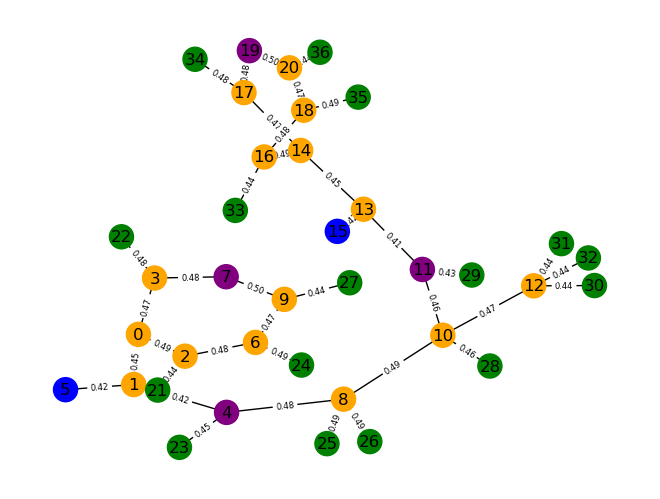

In [21]:
import evaluation
importlib.reload(evaluation)
# TODO: Work on different batch sizes

# TODO: Not working? Flips edge weights
data = evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, test_dataset, MUTAG)
w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)
edge_ij = mlp.sampleGraph(w_ij, temperature)

Graph = Data(x=data.x,edge_index=data.edge_index,edge_attr=edge_ij.detach())
pos1 = utils.plotGraph(Graph, pos=None, color_map=None, edge_weights=True, MUTAG=MUTAG)